In [ ]:
import numpy as np
import open3d as o3d
import yaml
from scipy.spatial.transform import Rotation as R
import imageio
import joblib
import copy
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import os
os.environ["DISPLAY"] = ":1"

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

def get_camera_space_point_cloud(color_img, depth_img, camera_params):
    """
    Generate point cloud in camera coordinate system
    
    Args:
        color_img (np.ndarray): RGB image, shape (H, W, 3), value range [0, 255]
        depth_img (np.ndarray): Depth image, shape (H, W), unit in meters
        camera_params (list): [fx, fy, cx, cy, width, height]
    
    Returns:
        o3d.geometry.PointCloud: Colored point cloud in camera coordinate system
    """
    # Get camera intrinsics
    fx, fy, cx, cy, width, height = camera_params
    
    # Create pixel coordinate grid
    v, u = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Convert depth image to 3D points
    z = depth_img  # Assume depth image unit is meters
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    
    # Reshape point cloud data to Nx3 format
    points = np.stack([x, y, z], axis=-1).reshape(-1, 3)
    colors = color_img.reshape(-1, 3) / 255.0
    
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    
    # Remove invalid points (depth is 0 or infinite)
    valid_mask = (z.reshape(-1) > 0) & (z.reshape(-1) < np.inf)
    valid_points = points[valid_mask]
    valid_colors = colors[valid_mask]
    
    # Set points and colors of the point cloud
    pcd.points = o3d.utility.Vector3dVector(valid_points)
    pcd.colors = o3d.utility.Vector3dVector(valid_colors)
    
    return pcd


In [ ]:
import cv2
from pathlib import Path

def estimate_pose(image, charuco_dict, intrinsics_matrix, dist_coeffs, board):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = cv2.aruco.detectMarkers(gray, charuco_dict)
    
    if len(corners) > 0:
        ret, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board) # can not pass
        if charuco_ids is not None and len(charuco_corners) > 3:
            valid, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, board, intrinsics_matrix, dist_coeffs, None, None)
            if valid:
                R_target2cam = cv2.Rodrigues(rvec)[0]
                t_target2cam = tvec.reshape(3, 1)
                target2cam = np.eye(4)
                target2cam[:3, :3] = R_target2cam
                target2cam[:3, 3] = t_target2cam.reshape(-1)
                return np.linalg.inv(target2cam)
    return None


charuco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.CharucoBoard((5, 5), 0.04, 0.03, charuco_dict)

def get_cam_2_marker(intrinsic_matrix, image):
    print(intrinsic_matrix)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cam_2_marker = estimate_pose(image, charuco_dict, intrinsic_matrix, np.zeros(5), board)
    if cam_2_marker is None:
        print("Marker not detected in the image")
        return
    return cam_2_marker

In [25]:

item_to_show = []
franka_points = np.load("/isaac-sim/src/tests/test-icp/franka_points.npy")
table_points = np.load("/isaac-sim/src/tests/test-icp/table_points.npy")
yaml_path = "/isaac-sim/src/configs/tools_config/collect_data_render_1021_eggplant_low_res_continuous.yaml"
image_root = "/isaac-sim/src/tests/init_pose_images/log-1731226187811-7247"
marker_2_base_start = Path("/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/assets/marker_2_base_1017.npy")
marker_2_base_start = np.load(marker_2_base_start)

print(franka_points.shape)
# pcd_array is a numpy array(7922, 3)
franka_pcd = o3d.geometry.PointCloud()
franka_pcd = o3d.geometry.PointCloud()
franka_pcd.points = o3d.utility.Vector3dVector(franka_points)
item_to_show.append(franka_pcd)

table_pcd = o3d.geometry.PointCloud()
table_pcd.points = o3d.utility.Vector3dVector(table_points)
# item_to_show.append(table_pcd)

# the frame base x y z is 0
frame_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
item_to_show.append(frame_base)
# o3d.visualization.draw_geometries(item_to_show)

(49244, 3)


In [26]:
import joblib

index = 1
mask_franka = joblib.load(f"{image_root}/mask-franka.pkl")
intrinsic = joblib.load(f"{image_root}/intrinsics.pkl")
camera_params = intrinsic[index]["fx"], intrinsic[index]["fy"], intrinsic[index]["ppx"], intrinsic[index]["ppy"], intrinsic[index]["width"], intrinsic[index]["height"]
image_rgb = imageio.imread(f"{image_root}/color_{index}.png") * mask_franka[:, :, np.newaxis]
image_depth = joblib.load(f"{image_root}/depth_{index}.pkl") * mask_franka
image_depth = np.where(image_depth > 1.5, 0, image_depth)
image_franka_pcd = get_camera_space_point_cloud(image_rgb, image_depth, camera_params)
image_depth.max()

mask_table = joblib.load(f"{image_root}/mask-table.pkl")
image_rgb = imageio.imread(f"{image_root}/color_{index}.png") * mask_table[:, :, np.newaxis]
image_depth = joblib.load(f"{image_root}/depth_{index}.pkl") * mask_table
image_depth = np.where(image_depth > 2.5, 0, image_depth)
image_table_pcd = get_camera_space_point_cloud(image_rgb, image_depth, camera_params)
image_depth.max()

/tmp/ipykernel_333271/1585227318.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_rgb = imageio.imread(f"{image_root}/color_{index}.png") * mask_franka[:, :, np.newaxis]
/tmp/ipykernel_333271/1585227318.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_rgb = imageio.imread(f"{image_root}/color_{index}.png") * mask_table[:, :, np.newaxis]


2.499000118696131

/tmp/ipykernel_333271/2837212858.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_rgb = imageio.imread(f"{image_root}/color_{index}.png")


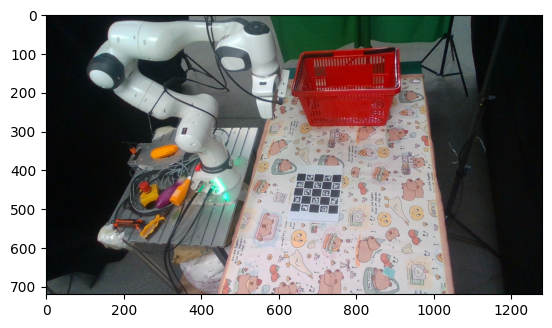

[[908.17651367   0.         641.16729736]
 [  0.         907.70526123 383.72457886]
 [  0.           0.           1.        ]]
Initial alignment
[[ 0.97288548  0.02595061 -0.22982689  0.3507401 ]
 [-0.1685171   0.76014261 -0.62752307  0.96724295]
 [ 0.15841661  0.64923784  0.74390483 -1.2194143 ]
 [ 0.          0.          0.          1.        ]]
RegistrationResult with fitness=6.380012e-01, inlier_rmse=5.295868e-03, and correspondence_set size of 177090
Access transformation to get result.
Apply point-to-point ICP
RegistrationResult with fitness=6.546241e-01, inlier_rmse=5.075484e-03, and correspondence_set size of 181704
Access transformation to get result.
Transformation is:
[[ 0.97226203  0.02017983 -0.23302213  0.35815834]
 [-0.16580915  0.76213883 -0.62582085  0.96265061]
 [ 0.16496625  0.64709905  0.74434465 -1.21904679]
 [ 0.          0.          0.          1.        ]]


In [27]:
from matplotlib import pyplot as plt
import open3d as o3d

intrinsic_matrix = np.array([[camera_params[0], 0, camera_params[2]],
                             [0, camera_params[1], camera_params[3]],
                             [0, 0, 1]])
image_rgb = imageio.imread(f"{image_root}/color_{index}.png")
# image_rgb = imageio.imread("/isaac-sim/src/tests/init_pose_images/log-1731226187811-7247/color_1.png")
plt.imshow(image_rgb)
plt.show()

cam_2_marker = get_cam_2_marker(intrinsic_matrix, image_rgb)
table_pcd.transform(np.linalg.inv(marker_2_base_start))
# draw_registration_result(image_table_pcd, table_pcd, cam_2_marker)
print("Initial alignment")
print(cam_2_marker)
threshold = 0.01
cam_2_marker_evaluation = o3d.pipelines.registration.evaluate_registration(
    image_table_pcd, table_pcd, threshold, cam_2_marker)
print(cam_2_marker_evaluation)
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    image_table_pcd, table_pcd, threshold, cam_2_marker,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
# draw_registration_result(image_table_pcd, table_pcd, reg_p2p.transformation)
camera_2_marker = reg_p2p.transformation

In [28]:
image_franka_pcd.transform(camera_2_marker)
draw_registration_result(image_franka_pcd, franka_pcd, marker_2_base_start)
print("Initial alignment")
print(marker_2_base_start)
threshold = 0.01
camera_2_marker_evaluation = o3d.pipelines.registration.evaluate_registration(
    image_franka_pcd, franka_pcd, threshold, marker_2_base_start)
print(camera_2_marker_evaluation)
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    image_franka_pcd, franka_pcd, threshold, marker_2_base_start,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(image_franka_pcd, franka_pcd, reg_p2p.transformation)
np.save("/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/assets/marker_2_base_1110.npy", reg_p2p.transformation)

Initial alignment
[[ 0.99916495 -0.03950491  0.00418786  0.32137021]
 [-0.03954903 -0.99902028  0.01695874  0.08417691]
 [ 0.00351871 -0.01711392 -0.99979847 -0.0514405 ]
 [ 0.          0.          0.          1.        ]]
RegistrationResult with fitness=8.250970e-02, inlier_rmse=6.351056e-03, and correspondence_set size of 7530
Access transformation to get result.
Apply point-to-point ICP
RegistrationResult with fitness=7.913918e-01, inlier_rmse=5.233113e-03, and correspondence_set size of 72224
Access transformation to get result.
Transformation is:
[[ 0.9979682  -0.04463872  0.04444642  0.3121263 ]
 [-0.04412011 -0.99889946 -0.01210406  0.08489811]
 [ 0.04494439  0.01011504 -0.99888945 -0.06524793]
 [ 0.          0.          0.          1.        ]]
